## Welcome to my NER pipeline!

In [1]:
!pip install transformers datasets tqdm scikit-multilearn

     |████████████████████████████████| 4.0 MB 4.2 MB/s 
     |████████████████████████████████| 325 kB 53.1 MB/s 
     |████████████████████████████████| 89 kB 7.9 MB/s 
     |████████████████████████████████| 895 kB 50.9 MB/s 
     |████████████████████████████████| 6.6 MB 37.6 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 47.9 MB/s 
     |████████████████████████████████| 212 kB 48.7 MB/s 
     |████████████████████████████████| 1.1 MB 26.7 MB/s 
     |████████████████████████████████| 136 kB 38.8 MB/s 
     |████████████████████████████████| 127 kB 39.8 MB/s 
     |████████████████████████████████| 144 kB 38.6 MB/s 
     |████████████████████████████████| 94 kB 980 kB/s 
     |████████████████████████████████| 271 kB 38.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    F

In [2]:
!nvidia-smi

Wed Apr 20 11:42:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## Choose whether to save on drive or locally:

gdrive = True
if gdrive:
    from google.colab import drive

    drive.mount( '/content/gdrive' )
    save_dir = '/content/gdrive/MyDrive/NER/final'
else:
    save_dir = './results/final'

Mounted at /content/gdrive


Get data from .bio file: 

In [4]:
def get_data(file_name):
    text = []
    data = []
    sample = []
    with open( file_name ) as b:
        for line in b.readlines():
            if line == '\n':
                sample_dict = {'text': [s[1].strip() for s in sample], 'labels': [s[0] for s in sample]}
                labels = []
                str_text = ''
                st = 0
                inside_lab = False
                for t, l in zip( sample_dict['text'], sample_dict['labels'] ):
                    # label ended:
                    if l[0] != 'I' and inside_lab:
                        inside_lab = False
                        end = len( str_text ) - 1
                        labels.append( [st, end, lab] )

                    #label started:
                    if l[0] == 'B':
                        lab = l.split( '-' )[1]
                        st = len( str_text )
                        inside_lab = True

                    str_text += t + ' '
                    # labels.append(st,end,l)
                if inside_lab:
                    end = len( str_text ) - 1
                    labels.append( [st, end, lab] )
                data.append( {"text": str_text.strip(), "labels": labels} )
                sample = []
            else:
                line = line.split( '\t' )
                sample.append( line )
            # [text.append(li[2]) for li in line]
    return data


In [5]:
import urllib.request

urllib.request.urlretrieve( "https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttest.bio",
                            "restauranttest.bio" )
urllib.request.urlretrieve( "https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttrain.bio",
                            "restauranttrain.bio" )

('restauranttrain.bio', <http.client.HTTPMessage at 0x7fc13cfd68d0>)

In [6]:
data = get_data( 'restauranttrain.bio' )

## Visualize distributions

Text(0.5, 0, 'Label')

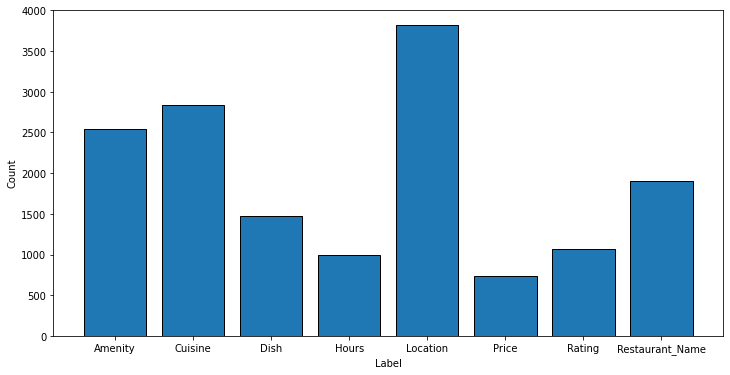

In [7]:
import matplotlib.pyplot as plt
import numpy as np

labls = [lab[-1] for sample in data for lab in sample['labels']]

fig = plt.figure( figsize=(12, 6) )
labls, counts = np.unique( labls, return_counts=True )
plt.bar( labls, counts, edgecolor='black' )

plt.ylabel( 'Count' )
plt.xlabel( 'Label' )

Text(0, 0.5, 'Count')

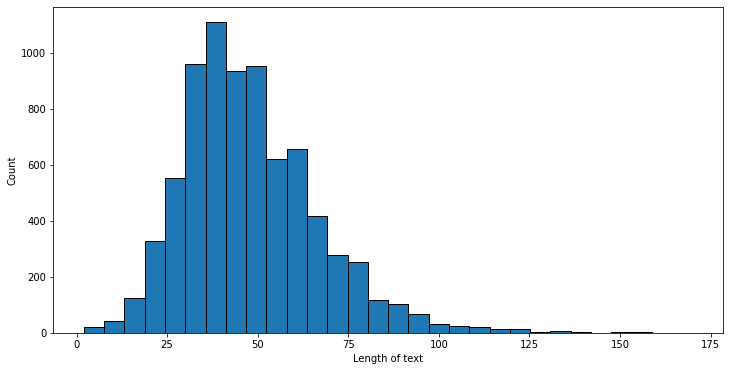

In [8]:
lengths = [len( sample['text'] ) for sample in data]

fig = plt.figure( figsize=(12, 6) )
plt.hist( lengths, edgecolor='black', bins=30 )
plt.xlabel( 'Length of text' )
plt.ylabel( 'Count' )

Text(0, 0.5, 'Count')

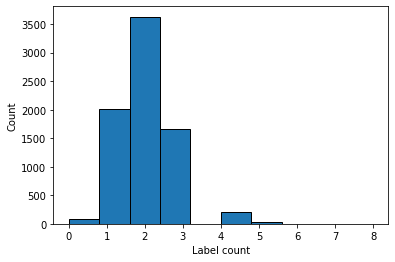

In [9]:
lab_c = [len( sample['labels'] ) for sample in data]
plt.hist( lab_c, edgecolor='black' )
plt.xlabel( 'Label count' )
plt.ylabel( 'Count' )

Text(0, 0.5, 'Label count')

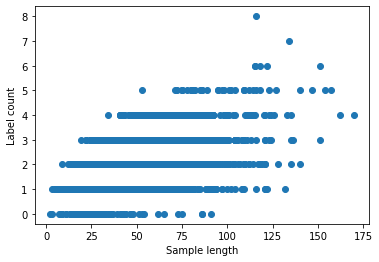

In [10]:
plt.scatter( lengths, lab_c )
plt.xlabel( 'Sample length' )
plt.ylabel( 'Label count' )

In [11]:
many_labs = [sample for sample in data if len( sample['labels'] ) > 5]
many_labs

[{'labels': [[14, 19, 'Cuisine'],
   [23, 33, 'Cuisine'],
   [46, 57, 'Location'],
   [73, 77, 'Dish'],
   [82, 98, 'Dish'],
   [110, 122, 'Dish']],
  'text': 'are there any vegan or vegetarian restaurants around here that cook with fake and substitute meats other than boca burgers'},
 {'labels': [[33, 39, 'Location'],
   [48, 54, 'Amenity'],
   [67, 78, 'Amenity'],
   [105, 109, 'Rating'],
   [110, 120, 'Cuisine'],
   [140, 151, 'Cuisine']],
  'text': 'i am trying to find a restaurant nearby that is casual and you can sit outside to eat somewhere that has good appetizers and food that is a light lunch'},
 {'labels': [[9, 30, 'Dish'],
   [35, 48, 'Dish'],
   [59, 66, 'Amenity'],
   [71, 90, 'Price'],
   [100, 104, 'Amenity'],
   [108, 118, 'Amenity']],
  'text': 'i want a large pepperoni pizza and buffalo wings that will deliver for under for 5 or less and will take my debit card'},
 {'labels': [[11, 16, 'Cuisine'],
   [33, 42, 'Amenity'],
   [43, 60, 'Dish'],
   [70, 82, 'Rating'],
  

In [12]:
zero_labs = [sample for sample in data if len( sample['labels'] ) == 0]
zero_labs

[{'labels': [], 'text': '34'},
 {'labels': [], 'text': 'are the proportions big or small'},
 {'labels': [],
  'text': 'are there any specialties being offered at any nearby restaurants'},
 {'labels': [], 'text': 'can i make online reservations'},
 {'labels': [], 'text': 'can i paid with a credit card here'},
 {'labels': [], 'text': 'can you find me a place to eat'},
 {'labels': [], 'text': 'can you find me a restaurant'},
 {'labels': [], 'text': 'can you help me find a place to eat'},
 {'labels': [], 'text': 'can you help me find food'},
 {'labels': [], 'text': 'can you make new recipes'},
 {'labels': [], 'text': 'can you take me to a good restaurant'},
 {'labels': [], 'text': 'car find a restaurant for me'},
 {'labels': [], 'text': 'car find places to eat'},
 {'labels': [], 'text': 'do you need a reservation'},
 {'labels': [], 'text': 'feed me'},
 {'labels': [], 'text': 'find a place for my food'},
 {'labels': [], 'text': 'find a restaurant'},
 {'labels': [], 'text': 'find food'},
 {'

In [13]:
long_text = [sample['text'] for sample in data if len( sample['text'] ) > 100]
long_text

['are than any sushi restaurants on the north side of town and i need to know their phone number and directions',
 'are there any chinese restaurants on east 86th street in manhattan where i can get takeout lunch specials',
 'are there any fine dining restaurants that allow me to eat my elegant meal in my car within 10 miles of here',
 'are there any good places to drink nearby i need a bar thats still open at this hour if you dont know the hours of operation give me a phone number so i can check',
 'are there any pizza places on the way home im looking for big portions so i can bring some home to the family',
 'are there any places on this side of town that serve mussels at a wonderful price and allow you to bring your own beverages',
 'are there any restaurants in this city with a dining room that have a great view of the night skyline',
 'are there any restuarants within 10 miles that are open until 2am that have a full service menu and serve alcohol',
 'are there any vegan or veget

In [14]:
short_text = [sample['text'] for sample in data if len( sample['text'] ) < 20]
short_text

['34',
 'after hour dining',
 'anniversary dinner',
 'any fastfood nearby',
 'any ihops around',
 'area restaurants',
 'asian',
 'asian by the river',
 'ballpark dining',
 'bbq joint in town',
 'beer and pub grub',
 'breakfast spot',
 'brunch',
 'buffet',
 'buffets nearest',
 'burger joint',
 'call applebees',
 'call mcdonalds',
 'call roys in oahu',
 'call sonic burger',
 'candy store',
 'cheap places to eat',
 'cheap restraunt',
 'chilis',
 'chinese',
 'chinese food joint',
 'chinese foooooood',
 'closest arbys',
 'closest bar in town',
 'closest indian food',
 'closest mcdonalds',
 'cookies',
 'cozy spot',
 'craving for steak',
 'craving for tacos',
 'donuts',
 'eateries',
 'expensive restraunt',
 'fast food',
 'fast food locations',
 'fastfood',
 'feed me',
 'find a cafe nearby',
 'find a fast food',
 'find a mcdonalds',
 'find a pizza parlor',
 'find a restaurant',
 'find dining',
 'find food',
 'find good food',
 'find me a cheap pub',
 'find me a del taco',
 'find me a dennys',


## Train NER

In [15]:
labels = list( set( [l[-1] for sample in data for l in sample['labels']] ) )

In [16]:
## Add category indices for labels:

tag2id = {tag: id for id, tag in enumerate( labels )}
id2tag = {id: tag for tag, id in tag2id.items()}

tag2id['none'] = len( tag2id )
id2tag[tag2id['none']] = 'none'
num_lables = len( tag2id )

In [17]:
## Label occurence for stratifier:

y = np.zeros( (len( data ), num_lables) )

for i, d in enumerate( data ):
    lbls = []
    for l in d['labels']:
        lbls.append( tag2id[l[-1]] )

    lbls = set( lbls )
    for lab in lbls:
        y[i][lab] = 1

#calculate total amount for each label:
counts = [(id2tag[i], v) for i, v in enumerate( y.sum( axis=0 ) )]
for l, c in counts:
    print( l, int( c ) )

Rating 1054
Dish 1401
Cuisine 2781
Amenity 2316
Hours 940
Restaurant_Name 1887
Location 3692
Price 727
none 0


In [18]:
## Stratification and kfold:

from skmultilearn.model_selection import IterativeStratification

test_size = 0.2
stratifier = IterativeStratification( n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0 - test_size] )
train_idx, val_idx = next( stratifier.split( data, y ) )


In [19]:
## Split data to train_val according to ids:

train_data = [data[idx] for idx in train_idx]
val_data = [data[idx] for idx in val_idx]


In [20]:
train_texts = [d['text'] for d in train_data]
val_texts = [d['text'] for d in val_data]


In [21]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

drop = 0.1
drop2 = 0.1
roberta_kwargs = {'hidden_dropout_prob': drop2, 'attention_probs_dropout_prob': drop, 'classifier_dropout': drop, }
model_name = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained( model_name )
model = AutoModelForTokenClassification.from_pretrained( model_name, num_labels=num_lables, **roberta_kwargs )

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream tas

In [22]:
train_encodings = tokenizer( train_texts, return_offsets_mapping=True, truncation=True, padding=True )
val_encodings = tokenizer( val_texts, return_offsets_mapping=True, truncation=True, padding=True )

In [23]:
#6# Encode tags:

def encode_tags(data, encodings, tag2id):
    encoded_labels = []
    for sample, doc_offset in zip( data, encodings.offset_mapping ):
        doc_encod_labels = np.ones( len( doc_offset ), dtype=int ) * -100
        for ind, (st, end) in enumerate( doc_offset ):
            if st == end:
                continue
            doc_encod_labels[ind] = tag2id['none']
            for lab in sample['labels']:
                if st >= lab[0] and end <= lab[1]:
                    doc_encod_labels[ind] = tag2id[lab[2]]
        encoded_labels.append( doc_encod_labels )
    return encoded_labels


In [24]:
train_labels = encode_tags( train_data, train_encodings, tag2id )
val_labels = encode_tags( val_data, val_encodings, tag2id )

In [25]:
np.unique( np.array( train_labels ).flatten() )

array([-100,    0,    1,    2,    3,    4,    5,    6,    7,    8])

In [26]:
from sklearn.utils.class_weight import compute_class_weight

labs = np.array( train_labels ).flatten()

In [27]:
labs = labs[labs != -100]
for i in id2tag:
    print( f"{id2tag[i]}: {labs[labs == i].shape[0]}" )

Rating: 1278
Dish: 2488
Cuisine: 4578
Amenity: 4430
Hours: 1843
Restaurant_Name: 4750
Location: 6680
Price: 854
none: 35214


In [28]:
## Compute class weights assuming equal importance of classes:

class_wts = compute_class_weight( 'balanced', classes=np.unique( labs ), y=labs )
class_wts = class_wts / class_wts.max()
class_wts

array([0.66823161, 0.34324759, 0.18654434, 0.19277652, 0.46337493,
       0.17978947, 0.12784431, 1.        , 0.02425172])

In [29]:
## Dataset class

import torch


class NERDataset( torch.utils.data.Dataset ):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor( val[idx] ) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor( self.labels[idx] )
        return item

    def __len__(self):
        return len( self.labels )


train_encodings.pop( "offset_mapping" )  # we don't want to pass this to the model
val_encodings.pop( "offset_mapping" )
train_dataset = NERDataset( train_encodings, train_labels )
val_dataset = NERDataset( val_encodings, val_labels )

In [30]:
import sklearn.metrics

class_cnt = len( tag2id )


## Metrics:
# We use tokenwise MACRO F1 (F1 score averaged over different classes) as a primary evaluation metric

def compute_metrics(p):
    predictions, labels = p
    labels = labels.flatten()
    predictions = np.argmax( predictions, axis=2 ).flatten()[labels != -100]
    labels = labels[labels != -100]
    macro_f1 = sklearn.metrics.f1_score( y_true=labels, y_pred=predictions, average='macro',
                                         labels=range( class_cnt - 1 ) )
    acc = sklearn.metrics.accuracy_score( y_true=labels, y_pred=predictions )
    return {
        "macro f1": macro_f1,
        "accuracy": acc,
    }

In [31]:
## Create trainer with weighted loss:

from transformers import Trainer
from torch import nn

dev = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fct = nn.CrossEntropyLoss( weight=torch.tensor( class_wts, dtype=torch.float32, device=dev ),
                                label_smoothing=0.001 )


class WeightedTrainer( Trainer ):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop( "labels" )
        labels = labels.view( -1 )
        outputs = model( **inputs )
        logits = outputs.logits.view( *labels.shape, -1 )
        logits = logits[labels != -100]
        labels = labels[labels != -100]
        loss = loss_fct( logits, labels )
        return (loss, outputs) if return_outputs else loss

In [32]:
# Train NER:
from transformers import TrainingArguments

# large batches since samples are short
training_args = TrainingArguments(
    overwrite_output_dir=True,
    output_dir='./results',  # output directory
    num_train_epochs=20,  # total number of training epochs
    per_device_train_batch_size=128,  # batch size per device during training
    per_device_eval_batch_size=512,  # batch size for evaluation
    warmup_steps=500,  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # strength of weight decay
    logging_dir='./logs',  # directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=100,
    save_steps=100,
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model='macro f1',
    greater_is_better=True,
    learning_rate=1e-4,
)

trainer = WeightedTrainer(
    model=model,  # the instantiated 🤗 Transformers model to be trained
    args=training_args,  # training arguments, defined above
    train_dataset=train_dataset,  # training dataset
    eval_dataset=val_dataset,  # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6128
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 960


Step,Training Loss,Validation Loss,Macro f1,Accuracy
100,0.537600,0.443181,0.747860,0.835850
200,0.265900,0.320387,0.834212,0.890836
300,0.176900,0.327778,0.855475,0.917676
400,0.156400,0.357767,0.851732,0.909848
500,0.151000,0.371089,0.860311,0.912644
600,0.097400,0.404161,0.862722,0.917055
700,0.085400,0.456874,0.865223,0.916558
800,0.064200,0.493099,0.864459,0.916993
900,0.052100,0.502246,0.872140,0.923703


***** Running Evaluation *****
  Num examples = 1532
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1532
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1532
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Model weights saved in ./results/checkpoint-300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1532
  Batch size = 512
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin


TrainOutput(global_step=960, training_loss=0.29305702491352953, metrics={'train_runtime': 735.935, 'train_samples_per_second': 166.536, 'train_steps_per_second': 1.304, 'total_flos': 1157324637732480.0, 'train_loss': 0.29305702491352953, 'epoch': 20.0})

In [33]:
trainer.save_model( save_dir )

Saving model checkpoint to /content/gdrive/MyDrive/NER/final
Configuration saved in /content/gdrive/MyDrive/NER/final/config.json
Model weights saved in /content/gdrive/MyDrive/NER/final/pytorch_model.bin


In [34]:
test_data = get_data( 'restauranttest.bio' )
test_texts = [d['text'] for d in test_data]
test_encodings = tokenizer( test_texts, return_offsets_mapping=True, truncation=True, padding=True )
test_labels = encode_tags( test_data, test_encodings, tag2id )
test_encodings.pop( "offset_mapping" )
test_dataset = NERDataset( test_encodings, test_labels )

In [35]:
trainer.evaluate( test_dataset )

***** Running Evaluation *****
  Num examples = 1521
  Batch size = 512


{'epoch': 20.0,
 'eval_accuracy': 0.9232239566741001,
 'eval_loss': 0.4701135456562042,
 'eval_macro f1': 0.8749798024905682,
 'eval_runtime': 2.4845,
 'eval_samples_per_second': 612.198,
 'eval_steps_per_second': 1.207}

## Inference pipeline

In [36]:
def load_model(path):
    model_name = 'distilroberta-base'
    tokenizer = AutoTokenizer.from_pretrained( model_name )
    model = AutoModelForTokenClassification.from_pretrained( path )
    return tokenizer, model

In [37]:
from transformers import Pipeline


class NERPipeline( Pipeline ):
    def _sanitize_parameters(self, **kwargs):
        postprocess_kwargs = {}
        if "tag2id" in kwargs:
            postprocess_kwargs["tag2id"] = kwargs["tag2id"]
        if "id2tag" in kwargs:
            postprocess_kwargs["id2tag"] = kwargs["id2tag"]
        return {}, {}, postprocess_kwargs

    def preprocess(self, inputs):
        model_input = self.tokenizer( inputs, return_offsets_mapping=True,
                                      truncation=True, padding=True )
        model_input["input_ids"] = torch.tensor( model_input["input_ids"] ).unsqueeze( 0 )
        model_input["attention_mask"] = torch.tensor( model_input["attention_mask"] ).unsqueeze( 0 )
        return model_input

    def _forward(self, model_inputs):
        om = model_inputs.pop( "offset_mapping" )
        outputs = self.model( **model_inputs )
        outputs['offset_mapping'] = om
        return outputs

    def postprocess(self, model_outputs, tag2id=tag2id, id2tag=id2tag):
        logits = model_outputs.logits
        pred = logits.argmax( dim=-1 ).squeeze().cpu().numpy()
        doc_offset = model_outputs.offset_mapping
        all_lab = []
        curr = tag2id['none']
        curr_start = 0
        curr_end = 0
        for ind, (start_pos, end_pos) in enumerate( doc_offset ):
            if start_pos == end_pos:
                continue
            lab = pred[ind]
            if lab != curr:
                if curr != tag2id['none']:
                    all_lab.append( [curr_start, curr_end, id2tag[curr]] )
                curr_start, curr_end = start_pos, end_pos
                curr = lab
            else:
                curr_end = end_pos

        return all_lab

In [38]:
tokenizer, model = load_model( save_dir )
pipe = NERPipeline( tokenizer=tokenizer, model=model )

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/distilroberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/42d6b7c87cbac84fcdf35aa69504a5ccfca878fcee2a1a9b9ff7a3d1297f9094.aa95727ac70adfa1aaf5c88bea30a4f5e50869c68e68bce96ef1ec41b5facf46
Model config RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,


In [39]:
input_batch = ["5 star resturants in my town",
               "a great lunch spot but open till 2 a m passims kitchen"]
outputs = pipe( input_batch )

Disabling tokenizer parallelism, we're using DataLoader multithreading already


In [40]:
for inp, out in zip( input_batch, outputs ):
    print( '\n\n### SAMPLE ###' )
    print( inp )
    for (start, end, label) in out:
        print( f'LABEL: {label}, TEXT: {inp[start:end]}' )



### SAMPLE ###
5 star resturants in my town
LABEL: Rating, TEXT: 5 star


### SAMPLE ###
a great lunch spot but open till 2 a m passims kitchen
LABEL: Rating, TEXT: great
LABEL: Hours, TEXT: lunch
LABEL: Hours, TEXT: open till 2 a m


## The end